In [ ]:
from importlib import reload
from collections.abc import Callable

from matplotlib import pyplot as plt
from matplotlib import cm, colors

import numpy as np
import jax
from jax import numpy as jnp
from jax.numpy import fft

import base_system
import base_solver
import base_optim
import solvers
import utils

import kse

reload(base_system)
reload(base_solver)
reload(base_optim)
reload(solvers)
reload(utils)

reload(kse)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray
pi = jnp.pi

In [ ]:
def plot_3d(
    data: jndarray, T0: float, Tf: float, dt: float, x0: float, xf: float
):
    """Create a surface plot.

    Parameters
    ----------
    data
        True or nudged states over a time period
        shape (number of time steps, number of spatial steps)
    T0, Tf
        Initial and final time values
    dt
        Time step between states
    x0, xf
        Endpoints of spatial domain
    """
    tn, xn = data.shape
    xls = jnp.linspace(x0, xf, xn)
    yls = jnp.arange(tn) * dt

    X, Y = jnp.meshgrid(xls, yls)

    zlim = (np.nanmin(data), np.nanmax(data))
    cmap = cm.viridis
    norm = colors.Normalize(*zlim)

    fig, ax = plt.subplots(
        1, 1, figsize=(10, 8), subplot_kw={"projection": "3d"}
    )
    ax.view_init(30, -75)

    ax.set_xlim(x0, xf)
    ax.set_ylim(T0, Tf)
    ax.set_zlim(*zlim)

    ax.plot_surface(X, Y, data, cmap=cmap)
    fig.colorbar(cm.ScalarMappable(norm, cmap), ax=ax, label="$u(x, t)$")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_zlabel("$u(x, t)$")

    fig.suptitle(rf"$u(x, t), \quad x \in [{T0}, {Tf}]$")
    fig.tight_layout()

    return fig, ax


def plot_contour(
    data: jndarray, T0: float, Tf: float, dt: float, x0: float, xf: float
):
    """Create a contour plot.

    Parameters
    ----------
    data
        True or nudged states over a time period
        shape (number of time steps, number of spatial steps)
    T0, Tf
        Initial and final time values
    dt
        Time step between states
    x0, xf
        Endpoints of spatial domain
    """
    tn, xn = data.shape
    xls = jnp.linspace(x0, xf, xn)
    yls = jnp.arange(tn) * dt

    X, Y = jnp.meshgrid(xls, yls)

    zlim = (np.nanmin(data), np.nanmax(data))
    cmap = cm.viridis
    norm = colors.Normalize(*zlim)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.set_xlim(x0, xf)
    ax.set_ylim(T0, Tf)

    ax.contourf(X, Y, data, cmap=cmap, extend="both")
    fig.colorbar(cm.ScalarMappable(norm, cmap), ax=ax, label="$u(x, t)$")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    fig.tight_layout()

    return fig, ax

In [ ]:
def get_initial_values(x0: float, xf: float, n: int):
    """Get initial values for the true and nudged states.

    Parameters
    ----------
    x0, xf
        Endpoints of domain
    n
        Number of spatial grid points on [x0, xf]

    Returns
    -------
    u0
        Initial true state
    un0
        Initial nudged state
    """
    rng = np.random.default_rng(42)
    u0 = 0.01 * rng.standard_normal(n)
    u0 -= np.mean(u0)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return fft.rfft(u0), fft.rfft(un0)


def plot(c1s, c2s, c3s, u_errors, g1, g2, g3, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(g1, ils[0], ils[-1], label="g1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs g1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(g2, ils[0], ils[-1], label="g2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs g2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.hlines(g3, ils[0], ils[-1], label="g3", color="black")
    ax.plot(ils, c3s, label="c3")
    ax.legend()
    ax.set_title("c3 vs g3")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# System evolution parameters
x0, xf = 0, 16 * 2 * np.pi
xn = 256
g1, g2, g3 = 1, 1, 1
c1, c2, c3 = g1, g2, g3
# c1 *= 1.5
c2 *= 1.5
# c3 *= 0.5

dt = 0.01
μ = 1.8 / dt

gs = jnp.array([g1, g2, g3], dtype=complex)
bs = jnp.array([])
cs = jnp.array([c1, c2, c3], dtype=complex)

# Update only those parameters that are different from the true values.
param_idx = np.nonzero(gs != cs)

observed_slice = jnp.s_[:32]
system = kse.KSE(μ, gs, bs, cs, observed_slice, x0, xf, xn)
solver = kse.SemiImplicitRK3(system)

# Optimizer
optimizer = lambda *_: system.cs
optimizer = base_optim.LevenbergMarquardt(system, 1e0)
optimizer = base_optim.PartialOptimizer(optimizer, param_idx)

# Learning rate scheduler
lr_scheduler = base_optim.DummyLRScheduler()

# Simulation parameters
T0, Tf = 0, 300
t_relax = 1
return_all = True

# plt.plot(jnp.linspace(x0, xf, xn), fft.irfft(get_initial_values(x0, xf, xn)[0]))
# plt.title("Initial condition")
# plt.show()

cs, u_errors, tls, true, nudged = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(x0, xf, xn),
    optimizer,
    lr_scheduler,
    return_all=return_all,
)

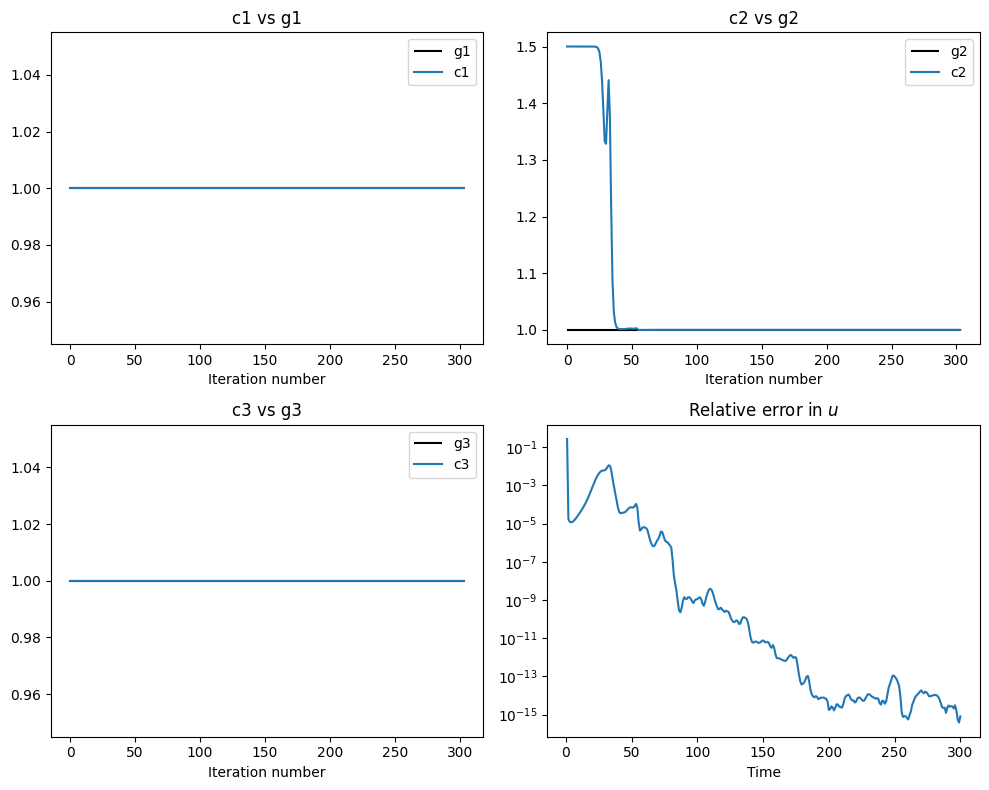

In [ ]:
fig, axs = plot(
    cs.real.T[0], cs.real.T[1], cs.real.T[2], u_errors, g1, g2, g3, tls
)
plt.show()

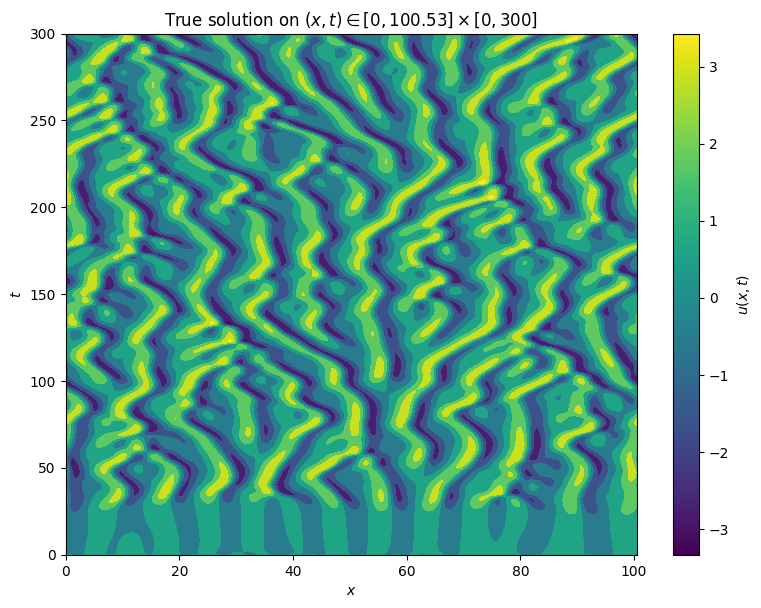

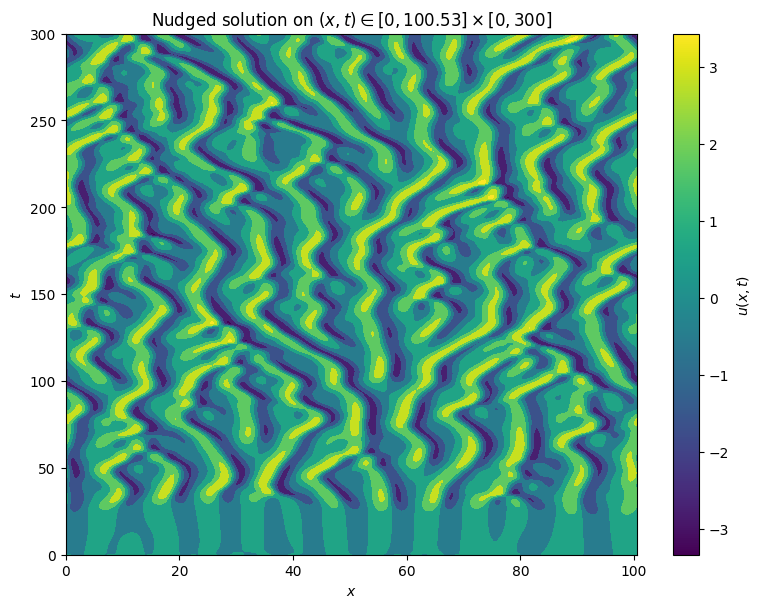

In [ ]:
_, ax = plot_contour(real_true := fft.irfft(true, axis=1), T0, Tf, dt, x0, xf)
ax.set_title(
    rf"True solution on $(x, t) \in [{x0}, {round(xf, 2)}] \times "
    rf"[{T0}, {Tf}]$"
)
plt.show()

_, ax = plot_contour(
    real_nudged := fft.irfft(nudged, axis=1), T0, Tf, dt, x0, xf
)
ax.set_title(
    rf"Nudged solution on $(x, t) \in [{x0}, {round(xf, 2)}] \times "
    rf"[{T0}, {Tf}]$"
)
plt.show()